<a href="https://colab.research.google.com/github/CreativeDragon1/BrainGuard/blob/main/train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BrainGuard - Alzheimer's MRI Detection
## Google Colab Training (Optimized for Speed)

In [1]:
!git clone https://github.com/CreativeDragon1/BrainGuard.git
%cd BrainGuard
!pip install -q torch torchvision torchaudio pandas scikit-learn pillow tqdm matplotlib

fatal: destination path 'BrainGuard' already exists and is not an empty directory.
/content/BrainGuard


### Upload Dataset

In [2]:
from google.colab import files
import os, shutil

print('Click Choose Files and upload: train.parquet and test.parquet')
uploaded = files.upload()
os.makedirs('Assets/Datasets/MRI Dataset', exist_ok=True)

for f in uploaded:
    if f.endswith('.parquet'):
        shutil.move(f, f'Assets/Datasets/MRI Dataset/{f}')
        print(f'Uploaded: {f}')

Click Choose Files and upload: train.parquet and test.parquet


Saving train.parquet to train.parquet
Saving test.parquet to test.parquet
Uploaded: train.parquet
Uploaded: test.parquet


In [3]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from pathlib import Path
import numpy as np, pandas as pd, io
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from models.cnn_model import ResNetModel

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [4]:
class MRIDataset(Dataset):
    def __init__(self, records, labels):
        self.records = records
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
    def __len__(self):
        return len(self.records)
    def __getitem__(self, idx):
        img = Image.open(io.BytesIO(self.records[idx])).convert('L')
        return self.transform(img), self.labels[idx]

In [5]:
# Load data
train_path = Path('Assets/Datasets/MRI Dataset/train.parquet')
test_path = Path('Assets/Datasets/MRI Dataset/test.parquet')

df_train = pd.read_parquet(train_path)
df_test = pd.read_parquet(test_path) if test_path.exists() else None

train_recs = [r['image']['bytes'] for _, r in df_train.iterrows()]
train_lbls = df_train['label'].tolist()

idx = np.arange(len(train_recs))
np.random.shuffle(idx)
split = int(0.1 * len(idx))

train_ds = MRIDataset([train_recs[i] for i in idx[split:]], [train_lbls[i] for i in idx[split:]])
val_ds = MRIDataset([train_recs[i] for i in idx[:split]], [train_lbls[i] for i in idx[:split]])

# OPTIMIZATION: num_workers=0 for Colab, pin_memory=True for GPU
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')
print(f'Batches: {len(train_loader)}')

Train: 4608, Val: 512
Batches: 72


In [7]:
# Training
model = ResNetModel(pretrained=True, num_classes=4).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

for epoch in range(50):
    # Train
    model.train()
    train_loss = train_acc = count = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (out.argmax(1) == lbls).sum().item()
        count += lbls.size(0)

    # Validate
    model.eval()
    val_loss = val_acc = val_count = 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            out = model(imgs)
            loss = criterion(out, lbls)
            val_loss += loss.item()
            val_acc += (out.argmax(1) == lbls).sum().item()
            val_count += lbls.size(0)

    train_loss /= len(train_loader)
    train_acc /= count
    val_loss /= len(val_loader)
    val_acc /= val_count

    history['loss'].append(train_loss)
    history['acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f'Ep {epoch+1}: Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}')

print('\nTraining complete!')

Ep 5: Loss=0.2537 Acc=0.9102 | Val Loss=0.6778 Val Acc=0.8125
Ep 10: Loss=0.0900 Acc=0.9677 | Val Loss=0.2632 Val Acc=0.9121
Ep 15: Loss=0.0675 Acc=0.9744 | Val Loss=0.4726 Val Acc=0.8770
Ep 20: Loss=0.0107 Acc=0.9965 | Val Loss=0.1198 Val Acc=0.9570
Ep 25: Loss=0.0266 Acc=0.9911 | Val Loss=0.0979 Val Acc=0.9648
Ep 30: Loss=0.0092 Acc=0.9970 | Val Loss=0.0738 Val Acc=0.9727
Ep 35: Loss=0.0445 Acc=0.9831 | Val Loss=0.4056 Val Acc=0.8926
Ep 40: Loss=0.0014 Acc=0.9998 | Val Loss=0.0497 Val Acc=0.9824
Ep 45: Loss=0.0001 Acc=1.0000 | Val Loss=0.0390 Val Acc=0.9863
Ep 50: Loss=0.0001 Acc=1.0000 | Val Loss=0.0315 Val Acc=0.9883

Training complete!


In [8]:
# Save
import os
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/best_resnet.pth')
print('Model saved!')

Model saved!


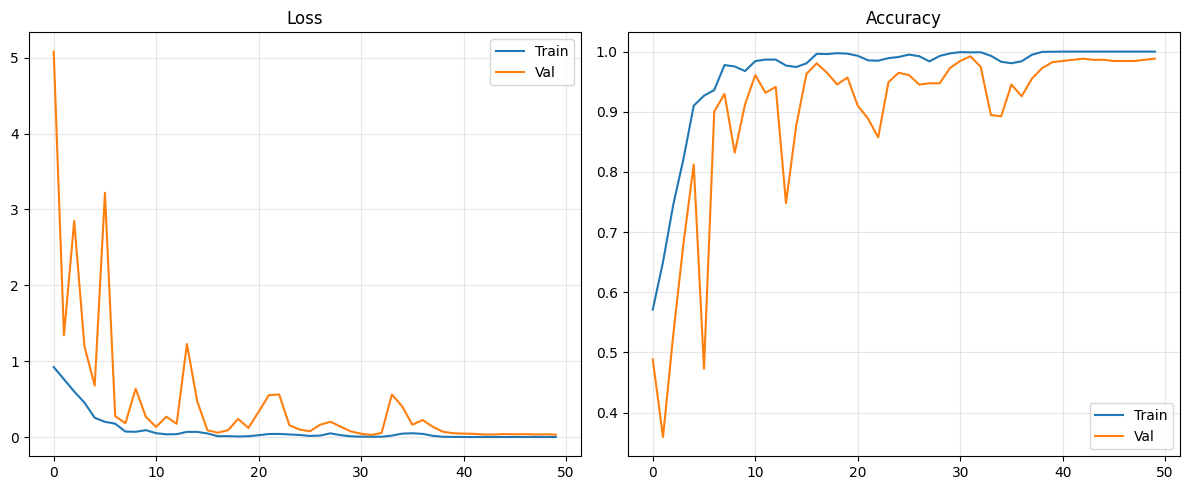

In [9]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results.png')
plt.show()

In [10]:
# Download
from google.colab import files
print('Downloading...')
files.download('models/best_resnet.pth')
files.download('results.png')
print('Done!')

Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!
